In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

In [ ]:
# Run src/data/combine_annotations.py first to generate the combined annotations file

In [3]:
frames = ["Economic","Capacity and resources","Morality","Fairness and equality","Legality, constitutionality and jurisprudence","Policy prescription and evaluation","Crime and punishment","Security and defense","Health and safety","Quality of life","Cultural identity","Public opinion","Political","External regulation and reputation","Other"]
frames = [f.lower() for f in frames]

In [5]:
frame_short_dict = {'economic': 'economic',
 'capacity and resources': 'cap&res',
 'morality': 'morality',
 'fairness and equality': 'fairness',
 'legality, constitutionality and jurisprudence': 'legality',
 'policy prescription and evaluation': 'policy',
 'crime and punishment': 'crime',
 'security and defense': 'security',
 'health and safety': 'health',
 'quality of life': 'quality_life',
 'cultural identity': 'culture',
 'public opinion': 'public_op',
 'political': 'political',
 'external regulation and reputation': 'regulation',
 'other': 'other'}

### Some filtering

In [6]:
analysis_path = Path('/projects/frame_align/data/annotated/analysis')
text_analysis_path = analysis_path / 'text'
vision_analysis_path = analysis_path / 'vision'

In [7]:
combined_df = pd.read_csv(analysis_path/'combined_annotations.csv')

In [10]:
combined_df['text_frame_name'] = combined_df['text_frame_name'].str.lower()
combined_df['vision_frame-name'] = combined_df['vision_frame-name'].str.lower()

In [11]:
text_valid = combined_df['text_frame_name'].isin(frames)
vision_valid = combined_df['vision_frame-name'].isin(frames)
intersection = text_valid & vision_valid
combined_df = combined_df[intersection]

In [17]:
annotated_uuids = combined_df['vision_uuid'].unique()

In [18]:
annotated_articles = []
data_dir = Path('/projects/frame_align/data/raw/2023-2024/')
for month_dir in data_dir.iterdir():
    if not month_dir.is_dir():
        continue
    df = pd.read_csv(month_dir/"datawithtopiclabels.csv")
    df = df[df['id'].isin(annotated_uuids)]
    annotated_articles.append(df)
annotated_articles = pd.concat(annotated_articles)
annotated_articles.to_csv(analysis_path/'annotated_uuid_articles.csv', index=False)

In [19]:
combined_df = combined_df.merge(annotated_articles[['id','topic_label']], left_on='text_id', right_on='id', how='left')

In [20]:
combined_df.to_csv(analysis_path/'combined_annotations_filtered.csv', index=False)

### Analysis

In [21]:
combined_df = pd.read_csv(analysis_path/'combined_annotations_filtered.csv')

In [23]:
len(combined_df)

103142

In [46]:
combined_df['text_frame_name'] = combined_df['text_frame_name'].map(frame_short_dict)
combined_df['vision_frame-name'] = combined_df['vision_frame-name'].map(frame_short_dict)

In [22]:
len(combined_df['topic_label'].unique())

11

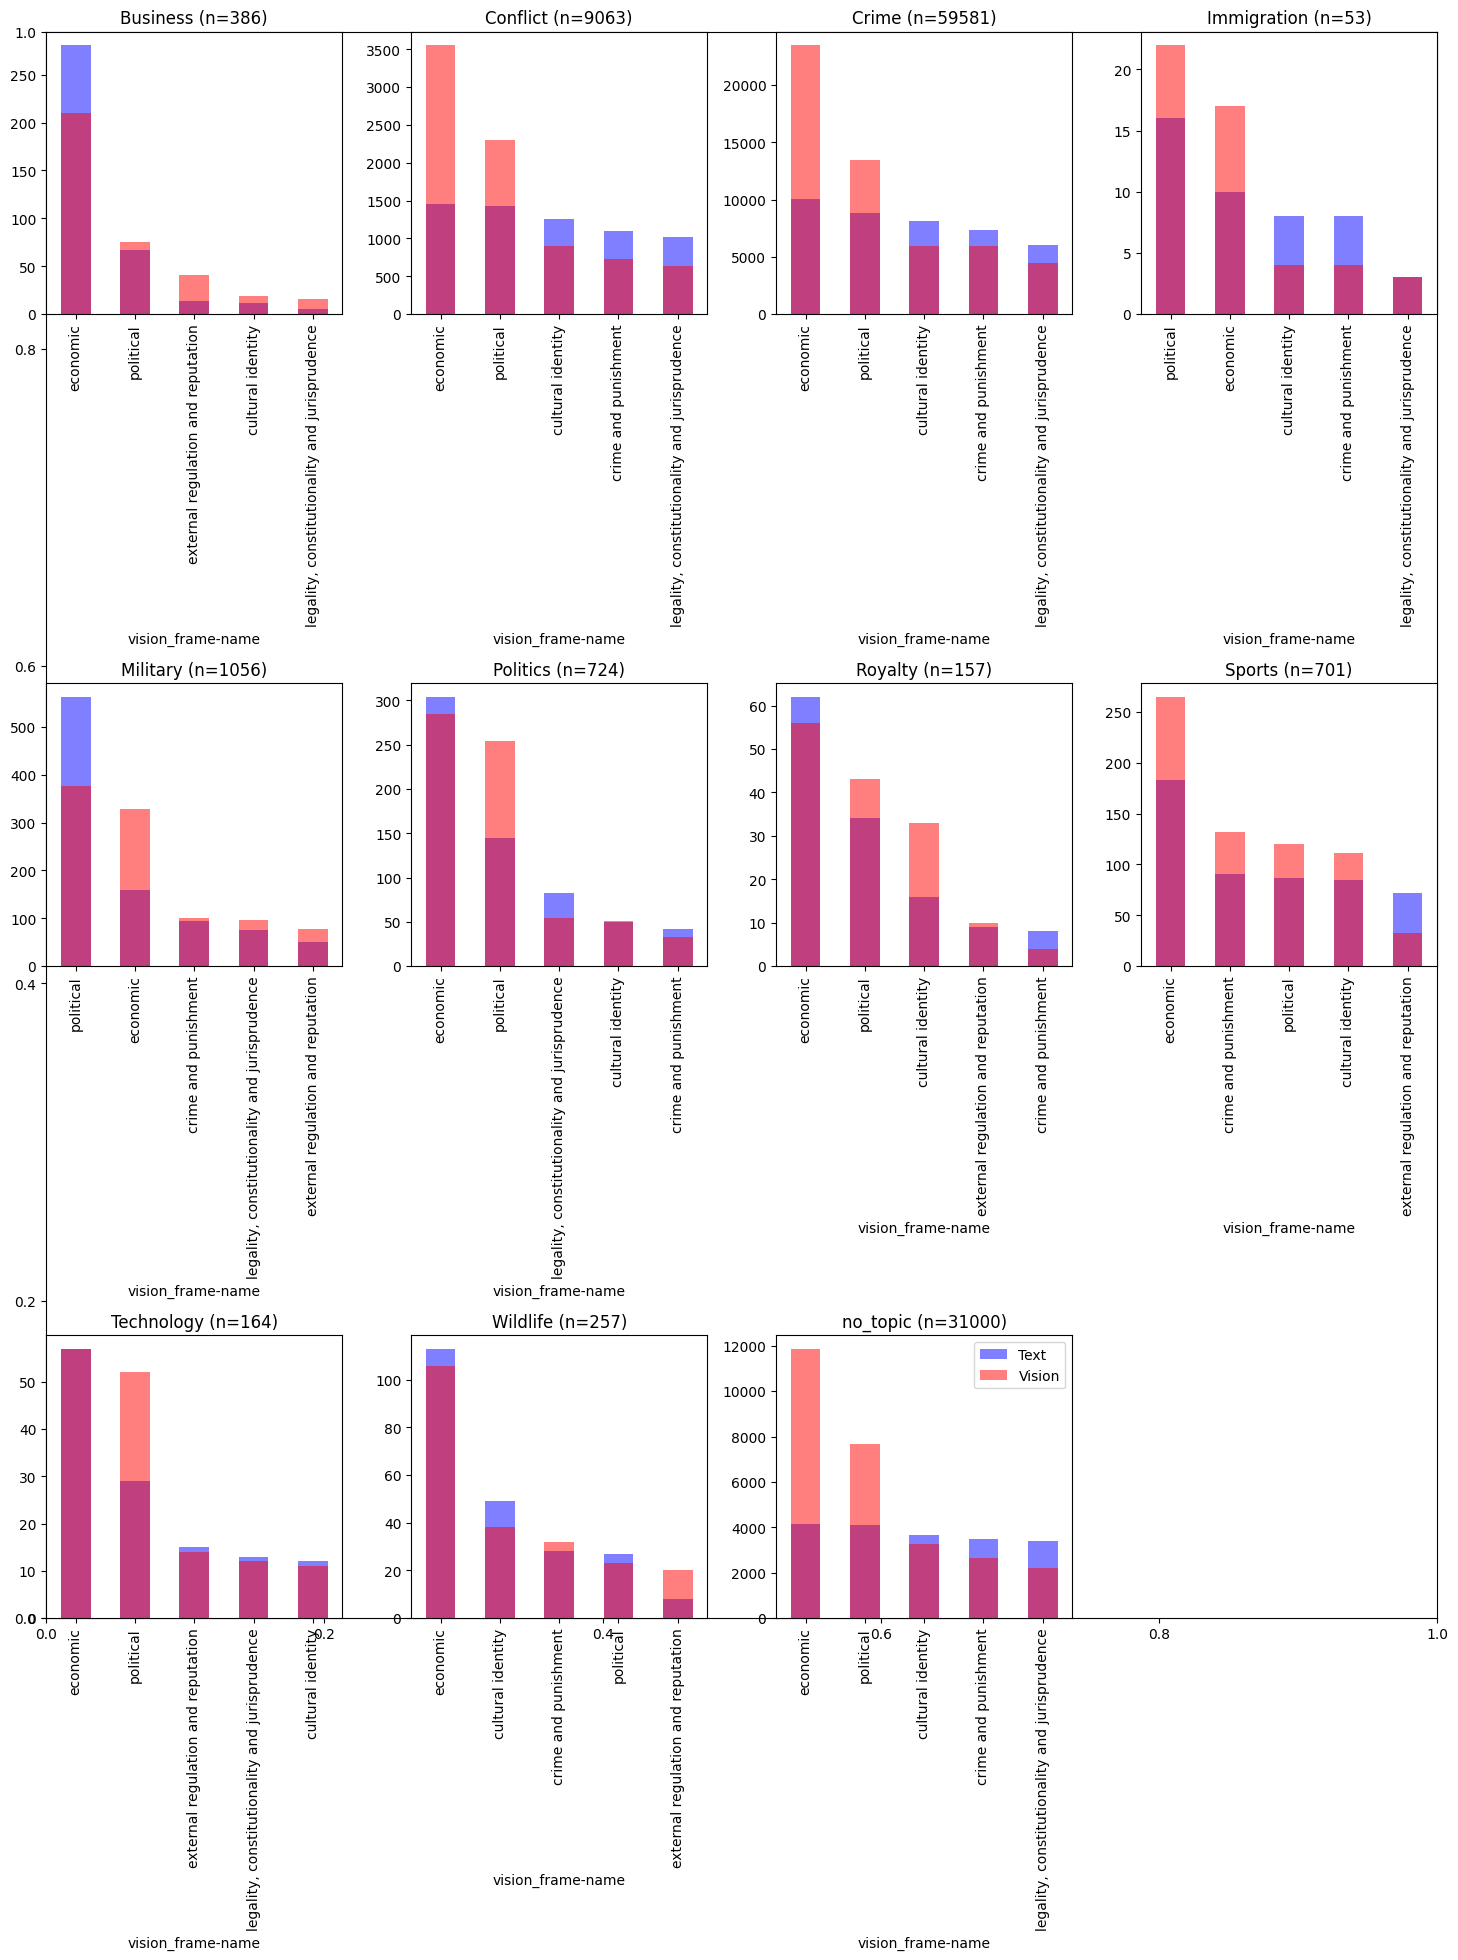

In [54]:
# Top text and vision frames per topic in stacked bar chart
plt.subplots(figsize=(15,20))
for i, (group_name, group) in enumerate(combined_df.groupby('topic_label')):
    plt.subplot(3,4,i+1)
    group['text_frame_name'].value_counts()[:5].plot(kind='bar', color='blue', alpha=0.5)
    group['vision_frame-name'].value_counts()[:5].plot(kind='bar', color='red', alpha=0.5)
    plt.title(group_name+' (n='+str(len(group))+')')
    plt.tight_layout()
plt.legend(['Text','Vision'])


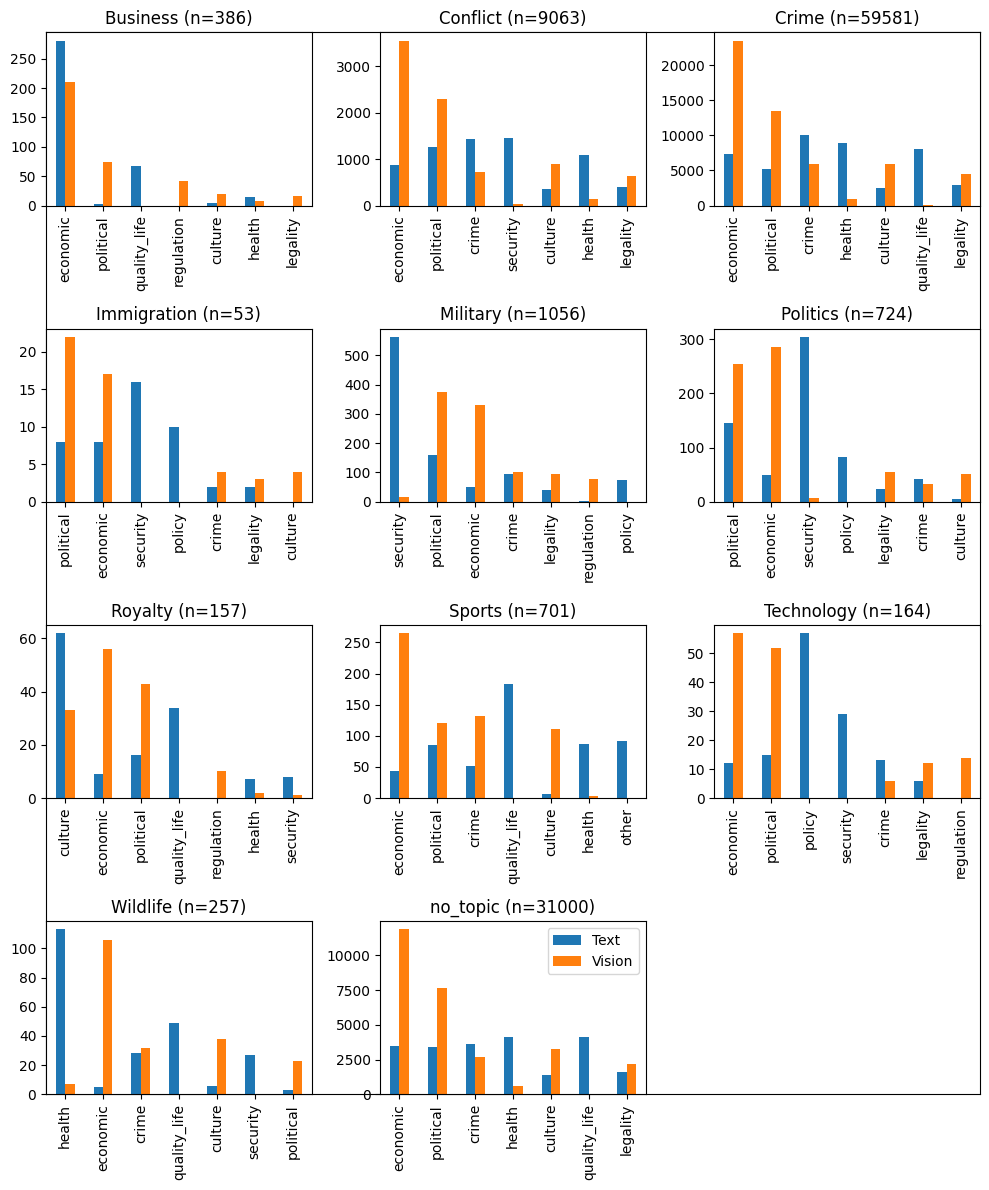

In [52]:
# Grouped bar plot for each topic
plt.subplots(figsize=(10,12))
plt.xticks([])
plt.yticks([])
for i, (group_name, group) in enumerate(combined_df.groupby('topic_label')):
    ax = plt.subplot(4,3,i+1)
    plt.title(group_name+' (n='+str(len(group))+')')
    group = group[['text_frame_name','vision_frame-name']].apply(pd.Series.value_counts)
    group['sum'] = group.sum(axis=1)
    group.sort_values('sum', ascending=False, inplace=True)
    group = group.head(7)
    group[['text_frame_name', 'vision_frame-name']].plot(kind='bar', ax=ax, legend=False)
    plt.tight_layout()
plt.legend(['Text','Vision'])